In [39]:
import os
from scipy import stats
import numpy as np
from scipy.stats import zscore
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.mplot3d.art3d import Line3DCollection
import pickle
import glob
import pandas as pd
from warnings import warn
import seaborn as sns
from dPCA import dPCA
import matplotlib.patheffects as pe


In [34]:
colors = ['dimgrey', 'coral']

mpl.rcParams.update({
    'axes.titlesize': 18,
    'axes.spines.bottom': True,
    'axes.spines.top': False,
    'axes.spines.left': True,
    'axes.spines.right': False,
    'xtick.bottom': True,
    'xtick.labelsize': 16,
    'ytick.labelsize': 16,
    'axes.linewidth': 1.5,
    'axes.edgecolor': 'black',
    'axes.facecolor': 'white',
    'axes.labelcolor': 'black',
    'axes.titlecolor': 'black',
    'axes.labelsize': 16,
    'ytick.labelcolor': 'black',
    'xtick.labelcolor': 'black',
    'legend.labelcolor': 'black',
    'legend.fontsize': 16
})

# Read in data from pickle files

In [5]:
# pickle files:
picklef = glob.glob("pickles2/loop_files/*.pickle")
print(pd.DataFrame([i.split("/")[-1] for i in picklef]))


                                      0
0    allSpikeData_ACC_direct_NoD.pickle
1  allSpikeData_DMS_indirect_NoD.pickle
2    allSpikeData_ACC_direct_AoE.pickle
3  allSpikeData_ACC_indirect_NoD.pickle
4  allSpikeData_DMS_indirect_AoE.pickle
5  allSpikeData_ACC_indirect_AoE.pickle
6    allSpikeData_DMS_direct_AoE.pickle
7    allSpikeData_DMS_direct_NoD.pickle


In [6]:
# pick a file:
fnum = 2
with open(picklef[fnum], "rb") as handle:
    data_all = pickle.load(handle)
keys = data_all.keys()
# selecting the key that includes single and multi-unit recordings:
key = [key for i, key in enumerate(keys) if key.split("_")[1] == "all"]
data = data_all[key[0]]

# strings used for plot titles later:
ephys_loc = picklef[fnum].split('_')[1][-3:]
opto_loc = picklef[fnum].split('_')[2][:-3]
task = picklef[fnum].split('_')[3][:3]


In [8]:
# pick a mouse and date:

mouseID = np.array(data["mouseID"])
print(f"mice: {np.unique(mouseID)}")
mouse_pick = 0  # pick mouse index here
mouse = np.unique(mouseID)[mouse_pick]

all_dates = np.asarray(data["date"])
# dates associated with that mouse:
dates = np.unique(all_dates[mouseID == mouse])
print(f"dates: {dates}")
date = dates[0]  # pick date index here

# index of mouse/dates of interest in data:
idx = np.nonzero((all_dates == date) * (mouseID == mouse))[0]
print(f"number of neurons for selected date & mouse: {idx.size}")


mice: [228. 231.]
dates: [20220820. 20220822. 20220831. 20220901. 20220902. 20220910. 20220912.
 20220914.]
number of neurons for selected date & mouse: 30


### Extract data for selected mouse/date:

In [15]:
bin_sizes = [5, 25, 15, 7, 15]
bin_locs = np.cumsum(bin_sizes)

# lists to store spike rate data for laser off and laser on trials
# and the trials' respective indices
# index 0 is laser off, index 1 is laser on
alldata_lsr = [None, None]
trial_idx_lsr = [None, None]

for laser in [0, 1]:
    # extracting index where the maze type is >7 for laser on vs off trials
    trial_idx = np.nonzero(
        (data["currMaze"][idx[0]] > 7) * (data["laserON"][idx[0]] == laser)
    )[0]
    # add the following to the trial index boolean operation to include only state 3 trials:
    # *(data['stateID'][idx[0]] == 3)

    trial_idx_lsr[laser] = trial_idx

    n_neurons = idx.size

    [n_trials, n_bins] = data["timeSqueezedFR"][idx[0]][trial_idx, :].shape

    alldata = np.zeros((n_trials, n_neurons, n_bins))

    correcttrials = np.where(
        data["choice"][idx[0]][trial_idx] == data["trialType"][idx[0]][trial_idx], 1, 0
    )
    print(
        f"fraction correct for laser {['off', 'on'][laser]}: {correcttrials.sum()}/{correcttrials.size}"
        f" = {correcttrials.sum()/correcttrials.size:.2f}"
    )

    # for each neuron, get time squeezed firing rate for all trials and time points:
    for i, id in enumerate(idx):
        alldata[:, i, :] = data["timeSqueezedFR"][id][trial_idx, :]

    alldata[np.isnan(alldata)] = 0  # replace nan values with 0

    alldata_lsr[laser] = alldata


fraction correct for laser off: 115/208 = 0.55
fraction correct for laser on: 42/57 = 0.74


# dPCA Analysis

[dPCA github](https://github.com/machenslab/dPCA)

### dPCA with laser and decision conditions:

In [16]:
# creating data matrices and fitting dPCA

choice1 = data["choice"][idx[0]][trial_idx_lsr[0]]  # laser off choices
choice2 = data["choice"][idx[0]][trial_idx_lsr[1]]  # laser on choices

# number of states for each experimental condition
n_time = n_bins
n_decision = 2
n_stim = 2

# finding the experimental condition with the least number of trials
# each condition should have the same number of trials for dPCA to work
n_trials = np.min(
    (
        alldata_lsr[0][choice1 == 0, :, :].shape[0],
        alldata_lsr[0][choice1 == 1, :, :].shape[0],
        alldata_lsr[1][choice2 == 0, :, :].shape[0],
        alldata_lsr[1][choice2 == 1, :, :].shape[0],
    )
)
print(f"number of trials included: {n_trials}")

# choosing random trials to include:
left_off_idx = np.random.randint(0, (choice1 == 0).sum(), n_trials)
right_off_idx = np.random.randint(0, (choice1 == 1).sum(), n_trials)
left_on_idx = np.random.randint(0, (choice2 == 0).sum(), n_trials)
right_on_idx = np.random.randint(0, (choice2 == 1).sum(), n_trials)

# data matrix which includes the average of all trials in each experimental condition:
X = np.empty((n_neurons, n_time, n_decision, n_stim))
X[:, :, 0, 0] = (alldata_lsr[0][choice1 == 0, :, :])[left_off_idx].mean(axis=0)
X[:, :, 1, 0] = (alldata_lsr[0][choice1 == 1, :, :])[right_off_idx].mean(axis=0)
X[:, :, 0, 1] = (alldata_lsr[1][choice2 == 0, :, :])[left_on_idx].mean(axis=0)
X[:, :, 1, 1] = (alldata_lsr[1][choice2 == 1, :, :])[right_on_idx].mean(axis=0)
X = X.transpose(0, 2, 3, 1)

# data matrix which includes each individual trial in each experimental condition,
# this is used for cross validation:
X_all = np.empty((n_trials, n_neurons, n_time, n_decision, n_stim))
X_all[:, :, :, 0, 0] = (alldata_lsr[0][choice1 == 0, :, :])[left_off_idx]
X_all[:, :, :, 1, 0] = (alldata_lsr[0][choice1 == 1, :, :])[right_off_idx]
X_all[:, :, :, 0, 1] = (alldata_lsr[1][choice2 == 0, :, :])[left_on_idx]
X_all[:, :, :, 1, 1] = (alldata_lsr[1][choice2 == 1, :, :])[right_on_idx]
X_all = X_all.transpose(0, 1, 3, 4, 2)

# mean centering each neuron:
X = X - X.mean(axis=(1, 2, 3)).reshape(-1, 1, 1, 1)
label = "dst"  # labeling the axes. d=decision/choice, s=laser/stim/inhib, t = time
dpca = dPCA.dPCA(labels="dst", n_components=3, regularizer="auto")
dpca.opt_regularizer_flag = True
dpca.n_trials = 5  # number of cross validation folds
dpca.protect = ["t"]  # prevents shuffling through time for cross validation
Xt = dpca.fit_transform(X, X_all)


number of trials included: 22
You chose to determine the regularization parameter automatically. This can
                    take substantial time and grows linearly with the number of crossvalidation
                    folds. The latter can be set by changing self.n_trials (default = 3). Similarly,
                    use self.protect to set the list of axes that are not supposed to get to get shuffled
                    (e.g. upon splitting the data into test- and training, time-points should always
                    be drawn from the same trial, i.e. self.protect = ['t']). This can significantly
                    speed up the code.
Start optimizing regularization.
Starting trial  1 / 5
Starting trial  2 / 5
Starting trial  3 / 5
Starting trial  4 / 5
Starting trial  5 / 5
Optimized regularization, optimal lambda =  0.002420143235548455
Regularization will be fixed; to compute the optimal                    parameter again on the next fit, please                    set opt_reg

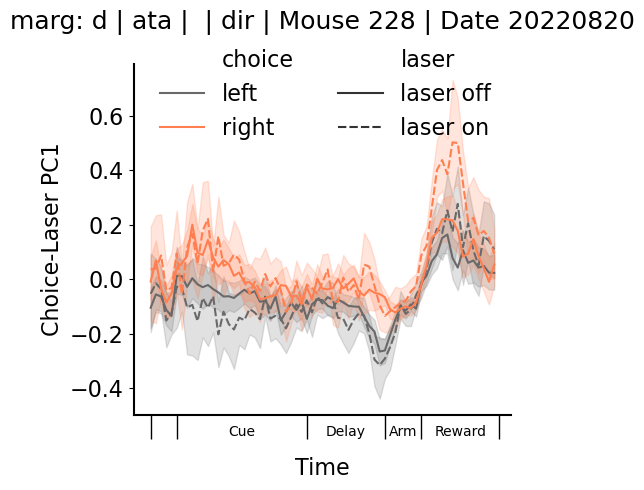

In [43]:
# transforming individual trials into dPCA space and plotting pc vs time
# choose marginalization here (e.g. 'd' for decision space, 'ds' for decision-laser space):
marg = "d"
pc = dpca.D[marg][:, :1]
choices = np.concatenate(
    (data["choice"][idx[0]][trial_idx_lsr[0]], data["choice"][idx[0]][trial_idx_lsr[1]])
)

# transforming laser off trials:
data_T_off = np.squeeze(alldata_lsr[0].transpose(0, 2, 1) @ pc, axis=2)
# transforming laser on trials:
data_T_on = np.squeeze(alldata_lsr[1].transpose(0, 2, 1) @ pc, axis=2)

data_T_all = np.concatenate((data_T_off, data_T_on), axis=0)
# vector indicating which trials are laser on vs off
lsr = np.where(
    np.arange(data_T_all.shape[0]) < data_T_off.shape[0], "laser off", "laser on"
)

# vector indicating which trials are left vs right choice
left_right = np.where(choices == 0, "left", "right")
if left_right[0] == "right":  # to keep left/right color scheme consistent
    colors = colors[::-1]

plot_df = pd.DataFrame(data_T_all, columns=np.arange(data_T_all.shape[1]))
plot_df["laser"] = lsr
plot_df["choice"] = left_right
plot_df = plot_df.melt(  # changing to long-form data frame to get error bars
    id_vars=["laser", "choice"], var_name="time", value_name="Choice-Laser PC1"
)

# plotting
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
sns.lineplot(
    data=plot_df,
    x="time",
    y="Choice-Laser PC1",
    hue="choice",
    style="laser",
    palette=colors,
    ax=ax,
)
ylim = plt.gca().get_ylim()

sns.despine()
plt.legend(loc="upper right", frameon=False, ncol=2, bbox_to_anchor=(1, 1.1))
plt.title(
    f"marg: {marg} | {ephys_loc} | {opto_loc} | {task} | Mouse {mouse:.0f} | Date {date:.0f}",
    pad=25
)

ax.set_xticks([0] + bin_locs.tolist())
ax.set_xticklabels([])
ax.tick_params('x', length=17, width=1, which='major')
ax.set_xlabel('Time', labelpad=10)

periods = ['', 'Cue', 'Delay', 'Arm', 'Reward']
for i in range(5):
    xloc = ([0] + bin_locs.tolist())[i] + bin_sizes[i]/2
    ax.text(xloc, -0.03, periods[i], fontsize=10, color='black', horizontalalignment='center',
        verticalalignment='top',
        transform = ax.get_xaxis_transform(),
        rotation=0)

plt.tight_layout()
plt.show()